In [1]:
#Necessary plugins
import unicodedata
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)
import warnings
warnings.simplefilter("ignore")




In this study, we wanted to find answers to some questions.
Who is more popular in social phantom media?
Are there people using social media to control elections?
Did someone use social media to promote or smear the two electors?
Did sentiment analysis show that people were more favorable to Biden? (so he could win the election)

In [2]:
# Read the data and check size
trump = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)
biden = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)

In [3]:
print('Trump dataset size: {}'.format(trump.shape))
print('Biden dataset size: {}'.format(biden.shape))

Trump dataset size: (725654, 21)
Biden dataset size: (499828, 21)


In [4]:
#general information
trump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725654 entries, 0 to 725653
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            725654 non-null  object 
 1   tweet_id              725654 non-null  float64
 2   tweet                 725654 non-null  object 
 3   likes                 725654 non-null  float64
 4   retweet_count         725654 non-null  float64
 5   source                724897 non-null  object 
 6   user_id               725654 non-null  float64
 7   user_name             725639 non-null  object 
 8   user_screen_name      725654 non-null  object 
 9   user_description      651481 non-null  object 
 10  user_join_date        725654 non-null  object 
 11  user_followers_count  725654 non-null  float64
 12  user_location         505267 non-null  object 
 13  lat                   342071 non-null  float64
 14  long                  342071 non-null  float64
 15  

In [5]:
#general information
biden.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499828 entries, 0 to 499827
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            499828 non-null  object 
 1   tweet_id              499828 non-null  float64
 2   tweet                 499828 non-null  object 
 3   likes                 499828 non-null  float64
 4   retweet_count         499828 non-null  float64
 5   source                499239 non-null  object 
 6   user_id               499828 non-null  float64
 7   user_name             499812 non-null  object 
 8   user_screen_name      499828 non-null  object 
 9   user_description      444977 non-null  object 
 10  user_join_date        499828 non-null  object 
 11  user_followers_count  499828 non-null  float64
 12  user_location         344420 non-null  object 
 13  lat                   234867 non-null  float64
 14  long                  234867 non-null  float64
 15  

In [6]:
#check top 5
trump.head(5)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [7]:
#check top 5
biden.head(5)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


First of all our task is an NLP task including visualization of meaningful and significant numbers. First we need to clean up the NaN values, calculate the number of tweets per day, and a detailed analysis of the text, such as word count and sentiment analysis. The tweets contain various emojis and hashtags, so we have to clean it up first.

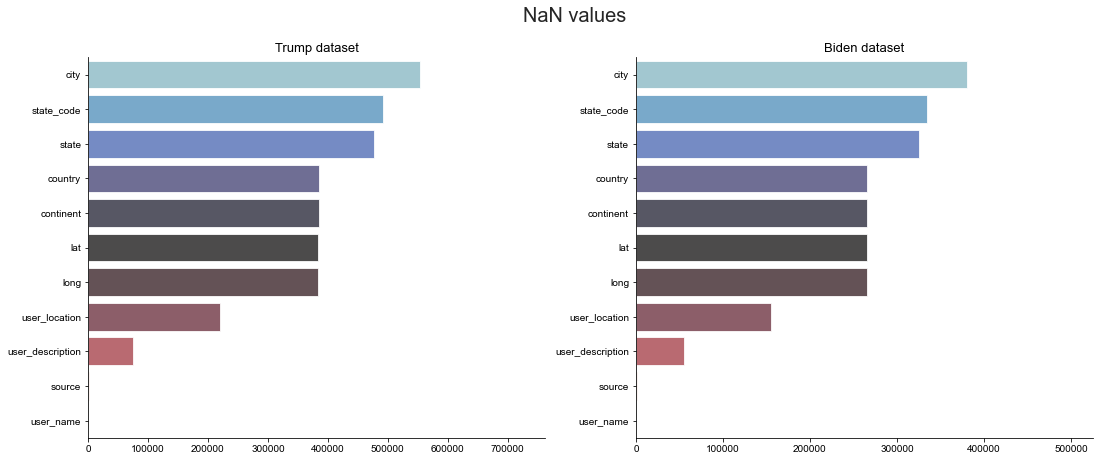

In [8]:
#NaN value
trump_nan = pd.Series(trump.isna().sum()[trump.isna().sum() > 0].sort_values(ascending = False))
biden_nan = pd.Series(biden.isna().sum()[biden.isna().sum() > 0].sort_values(ascending = False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
sns.set_style("whitegrid")

fig.suptitle('NaN values', size = 20)

sns.barplot(y = trump_nan.index, x = [len(trump)] * len(trump_nan),
            color = 'white', alpha = 0.6, ax = ax1)
sns.barplot(y = trump_nan.index, x = trump_nan, 
            alpha = 0.8, ax = ax1,
            palette = sns.color_palette("icefire", len(trump_nan)))
ax1.get_xaxis().get_major_formatter().set_scientific(False)
ax1.set_title('Trump dataset', size = 13)


sns.barplot(y = biden_nan.index, x = [len(biden)] * len(biden_nan),
            color = 'white', alpha = 0.6, ax = ax2)
sns.barplot(y = biden_nan.index, x = biden_nan, 
            alpha = 0.8, ax = ax2,
            palette = sns.color_palette("icefire", len(biden_nan)))
ax2.get_xaxis().get_major_formatter().set_scientific(False)
ax2.set_title('Biden dataset', size = 13)

sns.despine()

The chart shows the characteristics of data gaps in their distribution. Notably, there are an unusually high number of data gaps (over 60%) related to geographic variables. This may be due to the fact that few users post information with geographic location.

Such data should be used with caution. Although a small amount of missing data does not pose a problem in statistical analysis. However, a large amount of data may cast doubt on the reliability of the research conducted.

Donald Trump has more tweets than Joe Biden, but most of them don't get a lot of saves. Joe Biden's most popular tweet had more than 100,000 likes. This was the first difference we noticed in EDA

In [10]:
# the top of #donaldtrump tweets by likes
trump.sort_values('likes', ascending = False)[:5]

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
548590,2020-11-04 04:12:07,1.323840e+18,How did they call California for Joe Biden 8 m...,35449.0,6629.0,Twitter for iPhone,4.729379e+07,Terrence K. Williams,w_terrence,Actor• Comedian• My New Book “ From The Foster...,...,1190959.0,United States,39.783730,-100.445882,NaN,United States,North America,NaN,NaN,2020-11-05 12:16:23.532171
223920,2020-10-24 19:56:33,1.320092e+18,Experienced my first #Trump parade today....an...,26039.0,12181.0,Twitter for iPhone,8.015638e+17,Skillset Magazine,Skillsetmag,Redefining the Alpha Lifestyle 🇺🇸 Available na...,...,5645.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-27 17:42:32.283461
245075,2020-10-26 00:08:24,1.320518e+18,The White House still has not released a healt...,25987.0,5986.0,Twitter for iPhone,2.126745e+08,Paula Reid,PaulaReidCBS,@CBSNews White House Correspondent. Lawyer. re...,...,318675.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-27 17:38:26.623985
544650,2020-11-04 03:33:23,1.323831e+18,Blacks for Trump 2020 \n\nWe showed up for him...,23037.0,2652.0,Twitter for iPhone,4.729379e+07,Terrence K. Williams,w_terrence,Actor• Comedian• My New Book “ From The Foster...,...,1190960.0,United States,39.783730,-100.445882,NaN,United States,North America,NaN,NaN,2020-11-05 12:17:12.559484
295555,2020-10-28 06:02:59,1.321332e+18,Thousands of people left out in the cold and s...,22036.0,8731.0,Twitter for iPhone,1.707074e+07,Jeff Paul,Jeff_Paul,"TV News Hound, Record Junkie, Hot Sauce Connoi...",...,34318.0,"Los Angeles, CA (sometimes)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-29 17:20:31.861523


In [11]:
# the top of #joebiden tweets by likes
biden.sort_values('likes', ascending = False)[:5]

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
20432,2020-10-16 03:17:29,1.316941e+18,Tonight a woman in the audience of Trump's tow...,165702.0,17652.0,Twitter Web App,139823781.0,bettemidler,BetteMidler,Kindness is the language which the deaf can he...,...,2028360.0,"New York, NY",40.712728,-74.006015,New York,United States of America,North America,New York,NY,2020-10-21 02:59:56.181023787
10623,2020-10-15 17:09:02,1.316788e+18,The cowards at Twitter locked me out for expos...,143454.0,63473.0,Twitter for iPhone,78523300.0,James Woods,RealJamesWoods,This is the ONLY verified Twitter account for ...,...,2685154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 01:33:56.032148443
298112,2020-11-02 15:25:15,1.323285e+18,Good morning PENNSYLVANIA! I’m so excited to s...,126772.0,14024.0,Twitter for iPhone,14230524.0,Lady Gaga,ladygaga,“Chromatica” ⚔️💓 OUT NOW https://t.co/137uGkbr...,...,82417077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-03 14:34:27.602657
278831,2020-11-01 18:08:59,1.322964e+18,That’s a pic of me in Pennsylvania when I live...,80670.0,7553.0,Twitter for iPhone,14230524.0,Lady Gaga,ladygaga,“Chromatica” ⚔️💓 OUT NOW https://t.co/137uGkbr...,...,82396325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-02 16:18:06.846254
282938,2020-11-01 21:58:48,1.323022e+18,I AM SO EXCITED to be back in Pennsylvania! (P...,73648.0,6438.0,Twitter for iPhone,14230524.0,Lady Gaga,ladygaga,“Chromatica” ⚔️💓 OUT NOW https://t.co/137uGkbr...,...,82396310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-02 16:17:31.465432


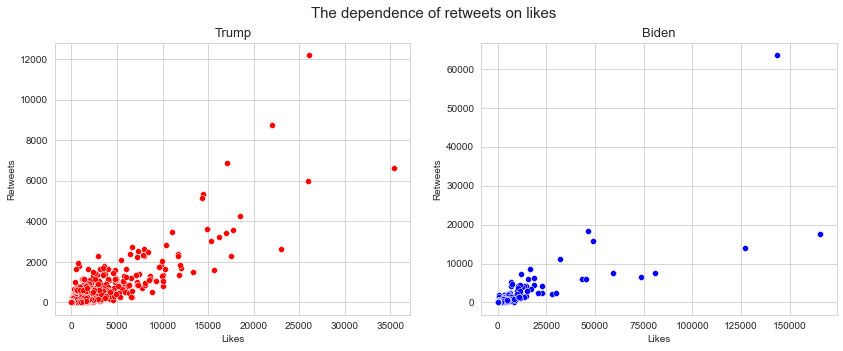

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.set_style("whitegrid")
fig.suptitle("The dependence of retweets on likes", size = 15)

sns.scatterplot(x = trump['likes'], y = trump['retweet_count'],
                color = 'red', ax = ax1)
ax1.get_yaxis().get_major_formatter().set_scientific(False)
ax1.set_xlabel('Likes')
ax1.set_ylabel('Retweets')
ax1.set_title('Trump', size = 13)


sns.scatterplot(x = biden['likes'], y = biden['retweet_count'],
                color = 'blue', ax = ax2)
ax2.get_yaxis().get_major_formatter().set_scientific(False)
ax2.set_xlabel('Likes')
ax2.set_ylabel('Retweets')
ax2.set_title('Biden', size = 13)

fig.show()

Through this graph we can easily find that there are more tweets about trump but get less likes and Biden the opposite. Although the correlation data is more logical, can we infer that someone is using social media to control public opinion?

In [72]:
print('Correlation between likes and retweets (Trump): {}'.format(trump['likes'].corr(trump['retweet_count'])))
print('Correlation between likes and retweets (Biden): {}'.format(biden['likes'].corr(biden['retweet_count'])))

Correlation between likes and retweets (Trump): 0.8698741705284073
Correlation between likes and retweets (Biden): 0.8089831856435488


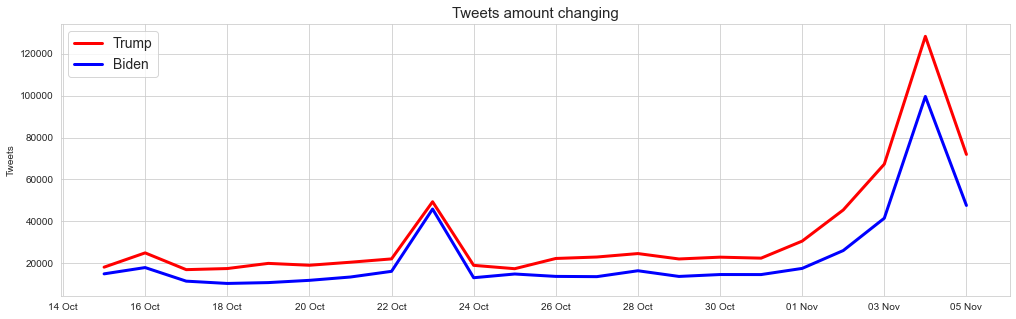

In [14]:
sns.set_style("whitegrid")
plt.figure(figsize=(17, 5))

ax = sns.lineplot(data = pd.to_datetime(trump.created_at).dt.date.value_counts(), 
                  label = 'Trump', color = 'red', linewidth = 3)
ax = sns.lineplot(data = pd.to_datetime(biden.created_at).dt.date.value_counts(), 
                  label = 'Biden', color = 'blue', linewidth = 3)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

plt.title('Tweets amount changing', size = 15)
plt.legend(prop={'size': 14})
plt.ylabel('Tweets')
plt.show()

The chart above shows that throughout the study period Donald Trump was a more popular target for tweets, but after November 6 this situation changed. It's related to election results and Joe Biden's victory. Two peaks in activity look logical: October 23 - the day after debate day, and November 4 - the day after Election Day.

In [16]:
trump['country'] = trump['country'].replace(['United States of America', 
                                             'United States'], 'USA')
biden['country'] = biden['country'].replace(['United States of America', 
                                             'United States'], 'USA')

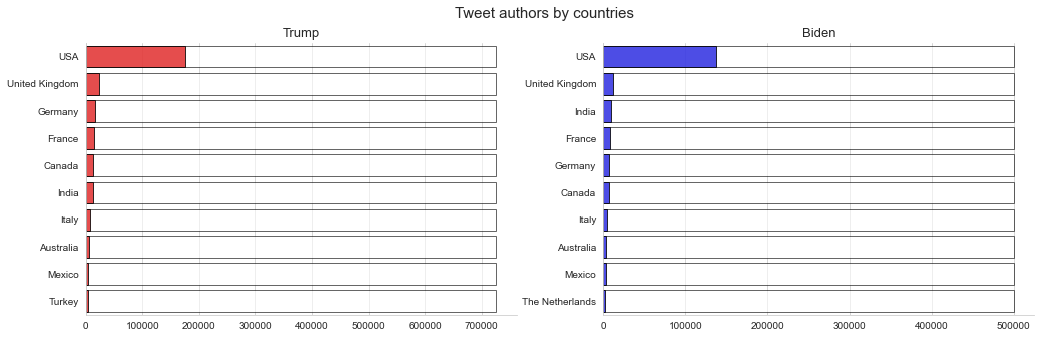

In [17]:
trump_tweets_countries = trump.country.value_counts()[:10]
biden_tweets_countries = biden.country.value_counts()[:10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
sns.set_style("whitegrid")
fig.suptitle("Tweet authors by countries", size = 15)

sns.barplot(y = trump_tweets_countries.index, x = [len(trump)] * len(trump_tweets_countries),
            edgecolor = 'black', color = 'white', alpha = 0.6, ax = ax1)
sns.barplot(y = trump_tweets_countries.index, x = trump_tweets_countries, 
            edgecolor = 'black', color = 'red', alpha = 0.8, ax = ax1)
ax1.get_xaxis().get_major_formatter().set_scientific(False)
ax1.set_xlabel('')
ax1.set_title('Trump', size = 13)


sns.barplot(y = biden_tweets_countries.index, x = [len(biden)] * len(biden_tweets_countries),
           edgecolor = 'black', color = 'white', alpha = 0.6, ax = ax2)
sns.barplot(y = biden_tweets_countries.index, x = biden_tweets_countries, 
            edgecolor = 'black', color = 'blue', alpha = 0.8, ax = ax2)
ax2.get_xaxis().get_major_formatter().set_scientific(False)
ax2.set_xlabel('')
ax2.set_title('Biden', size = 13)

sns.despine()

This chart we can see the authors from different countries, when I saw trump's chart inside the third rank is Germany I was very surprised, after searching I learned that the original old Trump has German ancestry. In the Biden chart will be more able to show the policy of the Democratic Party, they promote immigration policy reform for support.

In [18]:
# preparation of the geodata
tmp_tr = trump[['lat', 'long']].dropna()
tmp_bi = biden[['lat', 'long']].dropna()

geometry_tr = [Point(xy) for xy in zip(tmp_tr['long'], tmp_tr['lat'])]
geometry_bi = [Point(xy) for xy in zip(tmp_bi['long'], tmp_bi['lat'])]

geo_df_tr = gpd.GeoDataFrame(geometry = geometry_tr)
geo_df_bi = gpd.GeoDataFrame(geometry = geometry_bi)

wmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

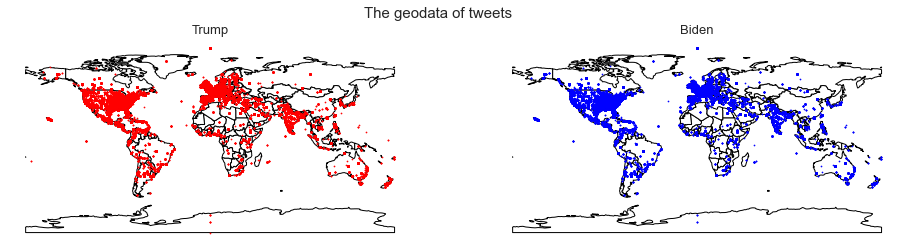

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), facecolor = 'white')
plt.text(x = -325, y = 120, s = "The geodata of tweets", fontsize = 15)

wmap.plot(ax = ax1, edgecolors='black', color = 'white')
geo_df_tr.plot(ax = ax1, markersize = 0.5, color = 'red')
ax1.set_title('Trump', size = 13)
ax1.axis('off')

wmap.plot(ax = ax2, edgecolors='black', color = 'white')
geo_df_bi.plot(ax = ax2, markersize = 0.5, color = 'blue')
ax2.set_title('Biden', size = 13)
ax2.axis('off')

fig.show()

When we visualize the location of all the tweeters, we can see that the main tweets are still coming from the US mainland and the UK in Europe.

In [73]:
print('Average number of likes per tweet (Trump): {}'.format(round(trump_agg['likes'].sum() / trump_agg['count'].sum(), 0)))
print('Average number of likes per tweet (Biden): {}'.format(round(biden_agg['likes'].sum() / biden_agg['count'].sum(), 0)))

Average number of likes per tweet (Trump): 7.0
Average number of likes per tweet (Biden): 9.0


Tweets dedicated to Joe Biden liked more often.

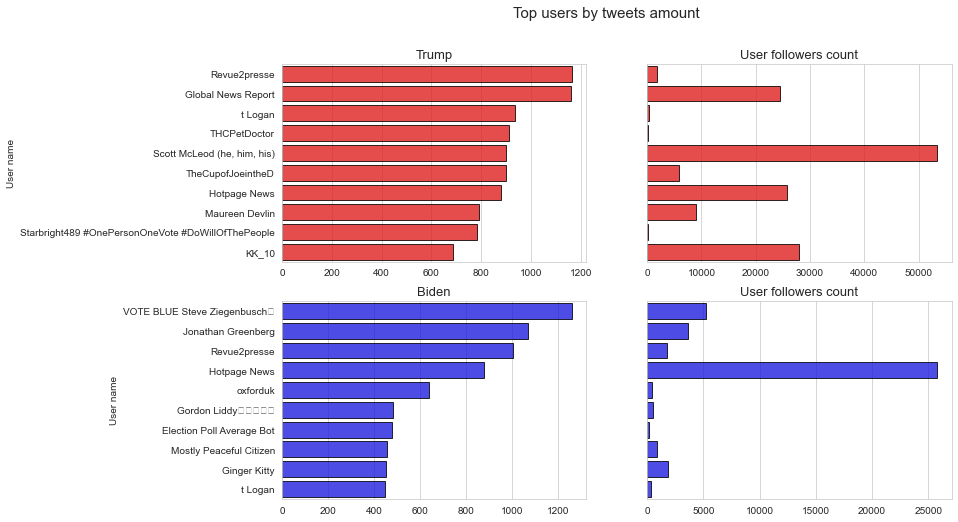

In [23]:
# User followers count
trump_user_followers = trump[['user_name', 
                              'user_followers_count']].groupby('user_name').max()
biden_user_followers = biden[['user_name', 
                              'user_followers_count']].groupby('user_name').max()

trump_top_authors_by_count = pd.merge(trump_agg[:10], trump_user_followers, 
                                      on = 'user_name', how = 'left')
biden_top_authors_by_count = pd.merge(biden_agg[:10], biden_user_followers, 
                                      on = 'user_name', how = 'left')

# Top users by tweets amount
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
sns.set_style("whitegrid")
fig.suptitle("Top users by tweets amount", size = 15)

sns.barplot(x = trump_agg['count'][:10], y = trump_agg['user_name'][:10],
            color = 'red', edgecolor = 'black', alpha = 0.8, ax = ax1)
ax1.get_xaxis().get_major_formatter().set_scientific(False)
ax1.set_xlabel('')
ax1.set_ylabel('User name')
ax1.set_title('Trump', size = 13)


sns.barplot(x = biden_agg['count'][:10], y = biden_agg['user_name'][:10],
            color = 'blue', edgecolor = 'black', alpha = 0.8, ax = ax3)
ax3.get_xaxis().get_major_formatter().set_scientific(False)
ax3.set_xlabel('')
ax3.set_ylabel('User name')
ax3.set_title('Biden', size = 13)


sns.barplot(x = trump_top_authors_by_count['user_followers_count'], 
            y = trump_top_authors_by_count['user_name'],
            color = 'red', edgecolor = 'black', alpha = 0.8, ax = ax2)
ax2.get_xaxis().get_major_formatter().set_scientific(False)
ax2.get_yaxis().set_visible(False)
ax2.set_xlabel('')
ax2.set_title('User followers count', size = 13)


sns.barplot(x = biden_top_authors_by_count['user_followers_count'], 
            y = biden_top_authors_by_count['user_name'],
            color = 'blue', edgecolor = 'black', alpha = 0.8, ax = ax4)
ax4.get_xaxis().get_major_formatter().set_scientific(False)
ax4.get_yaxis().set_visible(False)
ax4.set_xlabel('')
ax4.set_title('User followers count', size = 13)

fig.show()

Users who posted the most tweets have a small amount of followers.

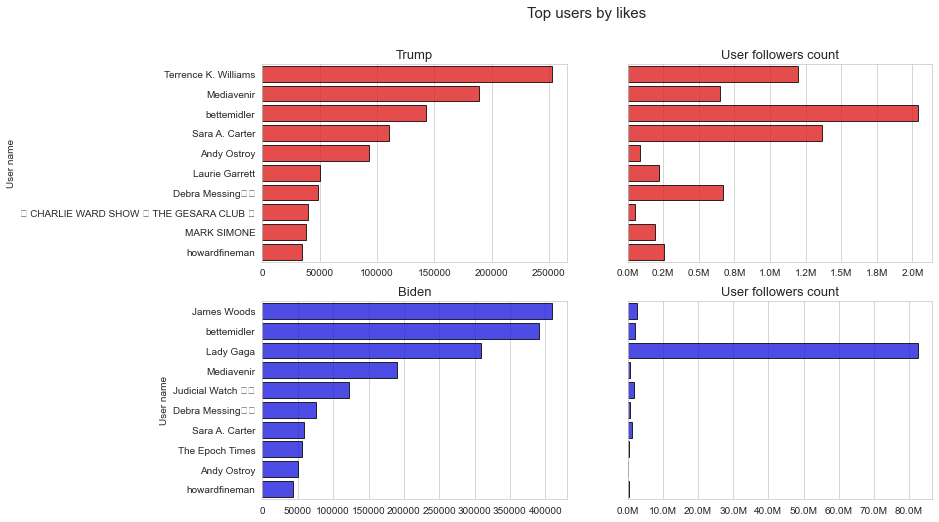

In [24]:
# User followers count
trump_top_authors_by_likes = pd.merge(trump_agg.sort_values('likes', ascending = False)[:10], 
                                      trump_user_followers, on = 'user_name', how = 'left')
biden_top_authors_by_likes = pd.merge(biden_agg.sort_values('likes', ascending = False)[:10], 
                                      biden_user_followers, on = 'user_name', how = 'left')

# Top users by likes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
sns.set_style("whitegrid")
fig.suptitle('Top users by likes', size = 15)

sns.barplot(x = trump_top_authors_by_likes['likes'], 
            y = trump_top_authors_by_likes['user_name'],
            color = 'red', edgecolor = 'black', alpha = 0.8, ax = ax1)
ax1.get_xaxis().get_major_formatter().set_scientific(False)
ax1.set_xlabel('')
ax1.set_ylabel('User name')
ax1.set_title('Trump', size = 13)


sns.barplot(x = biden_top_authors_by_likes['likes'], 
            y = biden_top_authors_by_likes['user_name'],
            color = 'blue', edgecolor = 'black', alpha = 0.8, ax = ax3)
ax3.get_xaxis().get_major_formatter().set_scientific(False)
ax3.set_xlabel('')
ax3.set_ylabel('User name')
ax3.set_title('Biden', size = 13)


sns.barplot(x = trump_top_authors_by_likes['user_followers_count'], 
            y = trump_top_authors_by_likes['user_name'],
            color = 'red', edgecolor = 'black', alpha = 0.8, ax = ax2)
ax2.xaxis.set_major_formatter(FuncFormatter(millions))
ax2.get_yaxis().set_visible(False)
ax2.set_xlabel('')
ax2.set_title('User followers count', size = 13)


sns.barplot(x = biden_top_authors_by_likes['user_followers_count'], 
            y = biden_top_authors_by_likes['user_name'],
            color = 'blue', edgecolor = 'black', alpha = 0.8, ax = ax4)
ax4.xaxis.set_major_formatter(FuncFormatter(millions))
ax4.get_yaxis().set_visible(False)
ax4.set_xlabel('')
ax4.set_title('User followers count', size = 13)

fig.show()

On the contrary, users whose tweets got many likes have far more followers, that looks logical. We will be able to classify these users into upholders or haters after sentiment analysis.

At first, we have to clean the data up. We'll use a great package [re](https://docs.python.org/3/library/re.html) for this. Let's look at the random tweets.

In [25]:
trump['tweet'][19529]

'Mad #Trump: "I borrowed the $400 million as a favor to those banks!"\n💰🤡💰\n\n(He keeps saying he\'s "underlevered" instead of "underleveraged" -which, of course, he\'s not.) \n\n#25thAmendmentNow'

In [26]:
biden['tweet'][11650]

'Hallo Twitter,\nwarum unterdrückst du eigentlich Nachrichten über Hunter #Biden? Hast du das überhaupt mit Barbra #Streisand abgesprochen? https://t.co/IUA98qkeBg'

As intended, tweets have various kinds of noise, like emojis, special symbols, newline tabulators, links, etc. Also, not all tweets wrote in English (like the tweet above).

In [27]:
# Tweet cleaner
def tweet_cleaner(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [28]:
trump_cleaned = trump.copy()
biden_cleaned = biden.copy()

trump_cleaned['tweet'] = trump_cleaned['tweet'].apply(lambda x: tweet_cleaner(x))
biden_cleaned['tweet'] = biden_cleaned['tweet'].apply(lambda x: tweet_cleaner(x))

In [29]:
trump_cleaned['tweet'][19529]

'mad trump i borrowed the  million as a favor to those banks   he keeps saying hes underlevered instead of underleveraged which of course hes not   '

In [30]:
biden_cleaned['tweet'][11650]

'hallo twitter warum unterdruckst du eigentlich nachrichten uber hunter biden hast du das uberhaupt mit barbra streisand abgesprochen '

Take a look at the length of tweets.

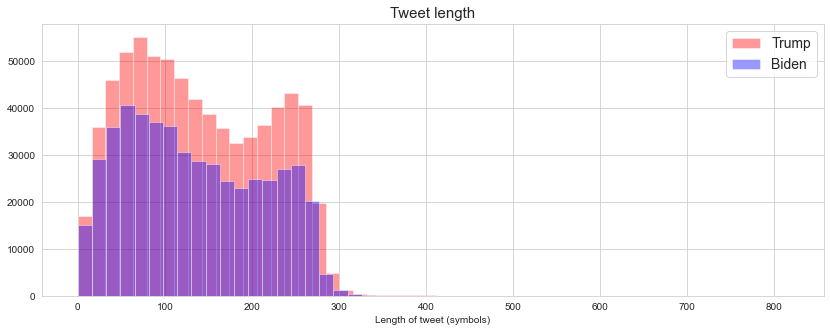

In [31]:
trump_tweet_length = trump_cleaned.tweet.str.len()
biden_tweet_length = biden_cleaned.tweet.str.len()

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))

sns.distplot(trump_tweet_length, label = 'Trump', color = 'red', kde = False)
sns.distplot(biden_tweet_length, label = 'Biden', color = 'blue', kde = False)
plt.legend(prop={'size': 14})
plt.title('Tweet length', size = 15)
plt.xlabel('Length of tweet (symbols)')
plt.show()

We see that on average, the distributions of tweet length for both candidates are the same.

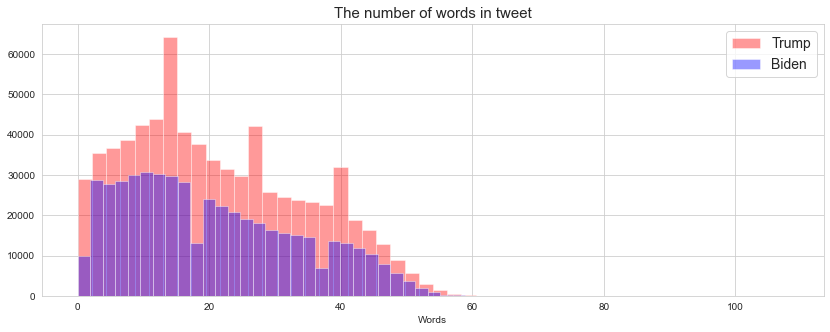

In [32]:
trump_words = trump_cleaned.tweet.str.split().map(lambda x: len(x))
biden_words = biden_cleaned.tweet.str.split().map(lambda x: len(x))

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))

sns.distplot(trump_words, label = 'Trump', color = 'red', kde = False)
sns.distplot(biden_words, label = 'Biden', color = 'blue', kde = False)
plt.legend(prop={'size': 14})
plt.title('The number of words in tweet', size = 15)
plt.xlabel('Words')
plt.show()

Almost the same. 

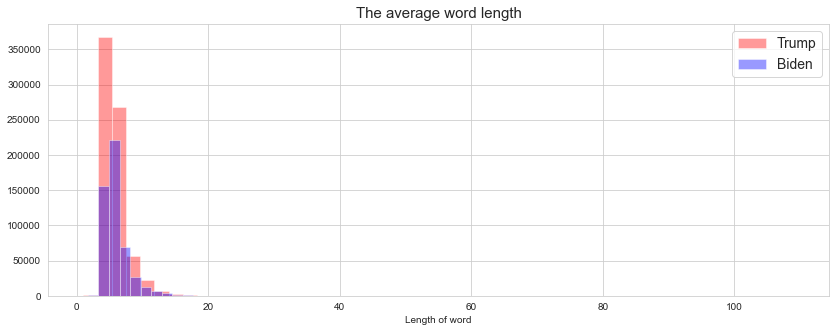

In [33]:
trump_word_len = trump_cleaned.tweet.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
biden_word_len = biden_cleaned.tweet.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))

sns.distplot(trump_word_len, label = 'Trump', color = 'red', kde = False)
sns.distplot(biden_word_len, label = 'Biden', color = 'blue', kde = False)
plt.legend(prop={'size': 14})
plt.title('The average word length', size = 15)
plt.xlabel('Length of word')
plt.show()

The chart above shows that almost all words have a range of lengths from 0 to 20. But there are some words with zero-length (NaN values), and, on the contrary, far longer than 20 letters (80, 100, and even more!). We'll remove only NaN-type outliers because long words are unique and don't have a powerful effect on data.

In [34]:
# Tweets with NaN length
trump_NaN_len = trump_word_len[trump_word_len.isnull()].index
biden_NaN_len = biden_word_len[biden_word_len.isnull()].index

# removing tweets with NaN length
trump_cleaned = trump_cleaned.drop(trump_NaN_len, axis = 0)
biden_cleaned = biden_cleaned.drop(biden_NaN_len, axis = 0)

In [35]:
# creating word lists
trump_corpus = []
words = trump_cleaned['tweet'].str.split().values.tolist()
trump_corpus = [word for i in words for word in i]

biden_corpus = []
words = biden_cleaned['tweet'].str.split().values.tolist()
biden_corpus = [word for i in words for word in i]

In [36]:
# word frequency
trump_counter = Counter(trump_corpus)
trump_most = trump_counter.most_common()

biden_counter = Counter(biden_corpus)
biden_most = biden_counter.most_common()

In [37]:
# The list of languages
stopwords.fileids()

['arabic',
 'azerbaijani',
 'basque',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [38]:
# Stopwords; we use English and Spanish as the most frequent in our data 
stop = set(np.concatenate((stopwords.words('english'), stopwords.words('spanish'))))

trump_x, trump_y = [], []
for word, count in trump_most[:100]:
    if word not in stop:
        trump_x.append(word)
        trump_y.append(count)
        
biden_x, biden_y = [], []
for word, count in biden_most[:100]:
    if word not in stop:
        biden_x.append(word)
        biden_y.append(count)

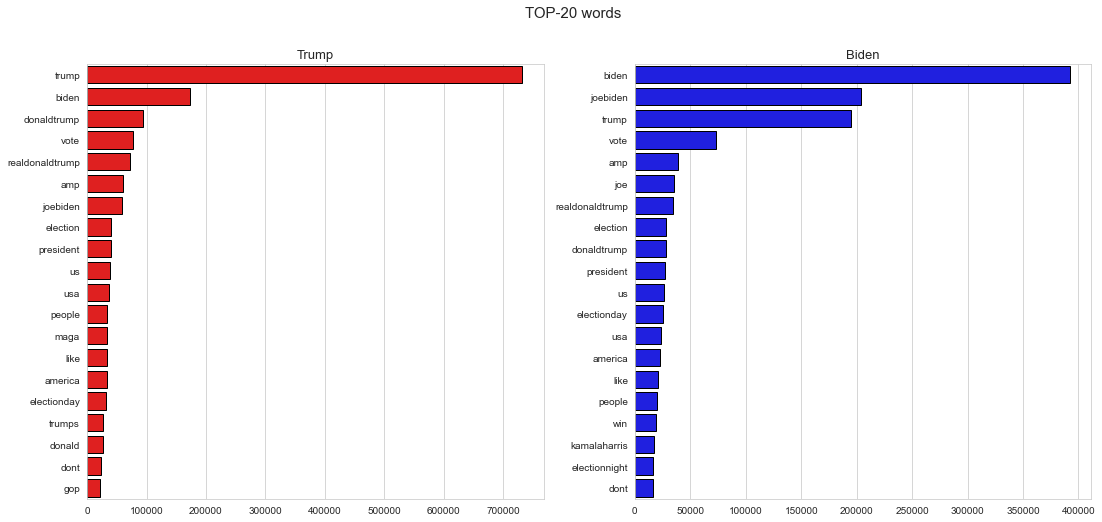

In [39]:
# TOP-20 words for both candidates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")
plt.suptitle('TOP-20 words', size = 15)

sns.barplot(x = trump_y[:20], y = trump_x[:20], edgecolor = 'black', color = 'red', ax = ax1)
ax1.set_title('Trump', size = 13)
ax1.get_xaxis().get_major_formatter().set_scientific(False)

sns.barplot(x = biden_y[:20], y = biden_x[:20], edgecolor = 'black', color = 'blue', ax = ax2)
ax2.set_title('Biden', size = 13)
ax2.get_xaxis().get_major_formatter().set_scientific(False)

fig.show()

Among the most frequent words in tweets dedicated to Donald Trump (excluding candidates' proper nouns) occur both popular election words: "vote", "election", "president", "people", "Election Day", etc., and specific, like "MAGA" (Trump's tagline "Make America Great Again") or "die" (a word with negative sense). Specific words of tweets dedicated to Joe Biden: "Kamala Harris" (Vice President-elect of the United States), "BidenHarris", "win" (a word that is more frequent regarding Joe Biden than Donald Trump). Let's look at Bi and Tri n-grams of words.

In [40]:
# ngrams of words
def get_top_ngram(corpus, n = None):
    vec = CountVectorizer(stop_words = stop, ngram_range = (n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq

### Top-10 bigrams

In [41]:
# Data for bigrams
top_trump_n_bigrams = get_top_ngram(trump_cleaned['tweet'], 2)[:10]
trump_x, trump_y = map(list, zip(*top_trump_n_bigrams))

top_biden_n_bigrams = get_top_ngram(biden_cleaned['tweet'], 2)[:10]
biden_x, biden_y = map(list, zip(*top_biden_n_bigrams))

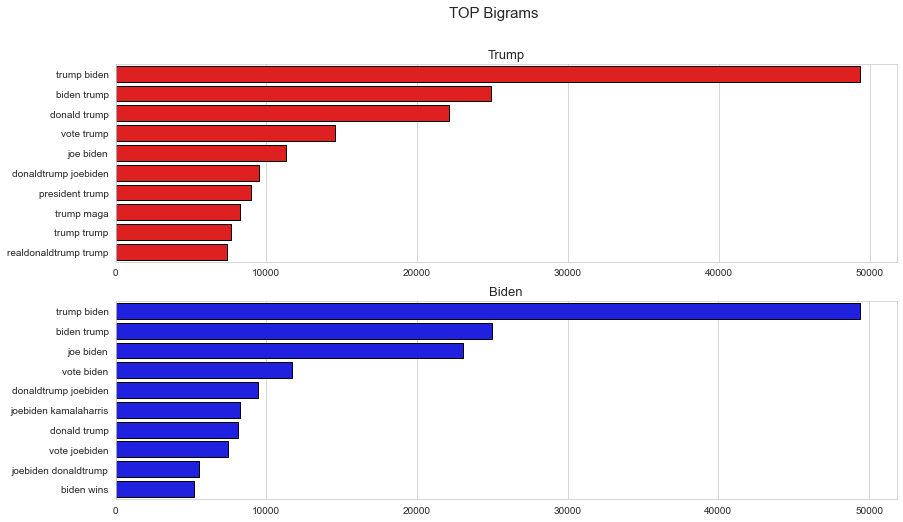

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
sns.set_style("whitegrid")
plt.suptitle('TOP Bigrams', size = 15)

sns.barplot(x = trump_y, y = trump_x, edgecolor = 'black', color = 'red', ax = ax1)
ax1.set_title('Trump', size = 13)
ax1.get_xaxis().get_major_formatter().set_scientific(False)

sns.barplot(x = biden_y, y = biden_x, edgecolor = 'black', color = 'blue', ax = ax2)
ax2.set_title('Biden', size = 13)
ax2.get_xaxis().get_major_formatter().set_scientific(False)

fig.show()

### Top-10 trigrams

In [43]:
# Data for trigrams
top_trump_n_bigrams = get_top_ngram(trump_cleaned['tweet'], 3)[:10]
trump_x, trump_y = map(list, zip(*top_trump_n_bigrams))

top_biden_n_bigrams = get_top_ngram(biden_cleaned['tweet'], 3)[:10]
biden_x, biden_y = map(list, zip(*top_biden_n_bigrams))

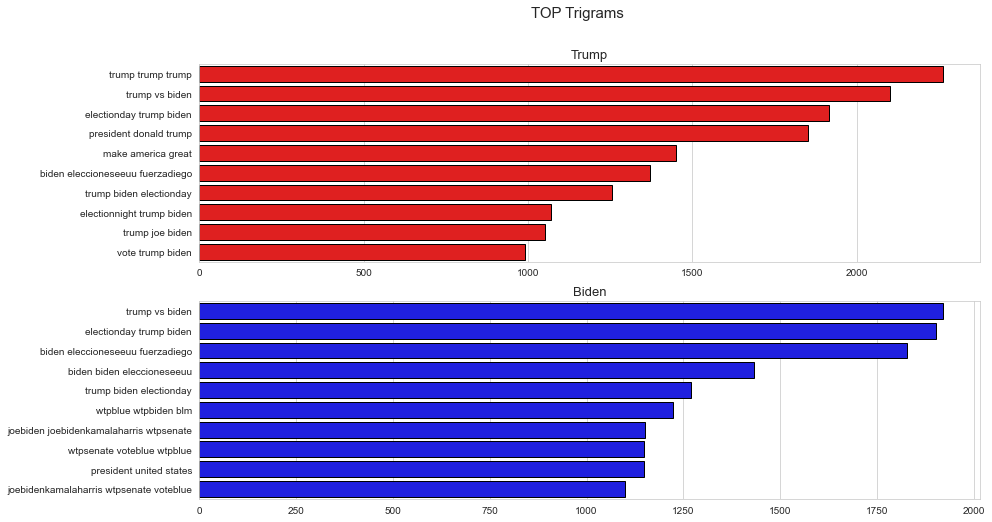

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
sns.set_style("whitegrid")
plt.suptitle('TOP Trigrams', size = 15)

sns.barplot(x = trump_y, y = trump_x, edgecolor = 'black', color = 'red', ax = ax1)
ax1.set_title('Trump', size = 13)
ax1.get_xaxis().get_major_formatter().set_scientific(False)

sns.barplot(x = biden_y, y = biden_x, edgecolor = 'black', color = 'blue', ax = ax2)
ax2.set_title('Biden', size = 13)
ax2.get_xaxis().get_major_formatter().set_scientific(False)

fig.show()

### Wordclouds

In [45]:
def show_wordcloud(data, title = None, color = 'white'):
    wordcloud = WordCloud(background_color=color,
                         stopwords=stop,
                         max_words=10000,
                         scale=3,
                         width = 4000, 
                         height = 2000,
                         collocations=False,
                         random_state=1)
    
    wordcloud = wordcloud.generate(str(data))
    
    plt.figure(1, figsize=(16, 8))
    plt.title(title, size = 15)
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

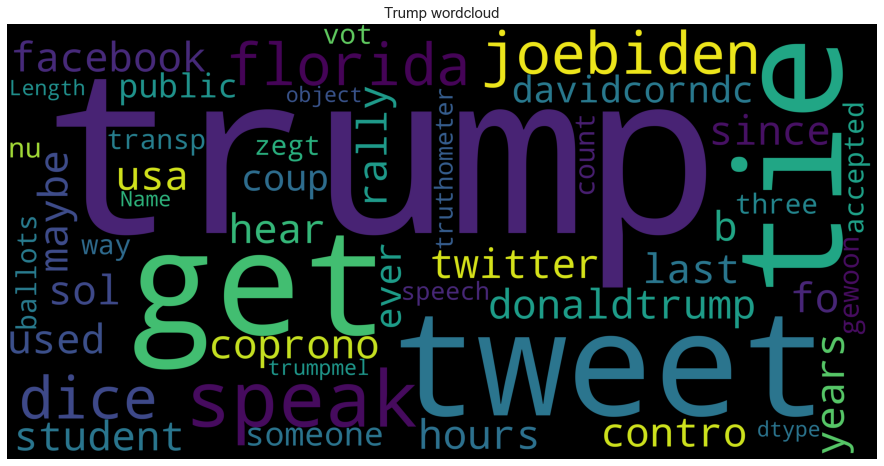

In [46]:
show_wordcloud(trump_cleaned['tweet'].dropna(), title = 'Trump wordcloud', color = 'black')

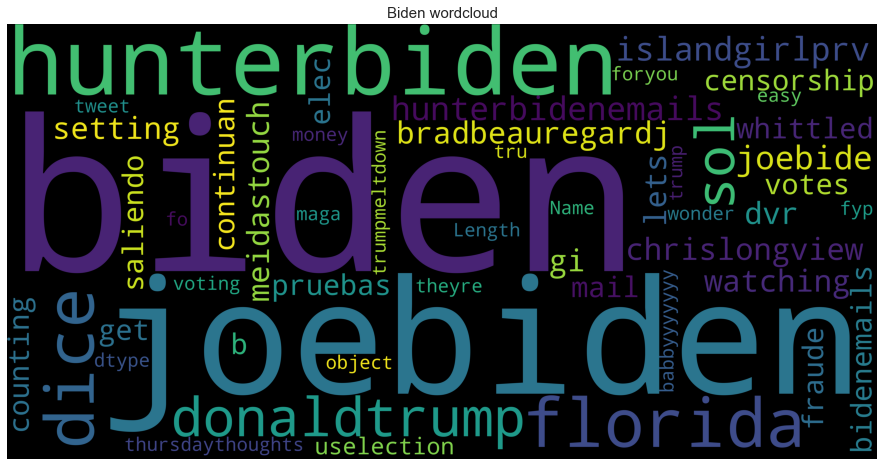

In [47]:
show_wordcloud(biden_cleaned['tweet'].dropna(), title = 'Biden wordcloud', color = 'black')

Now, it's time for **sentiment analysis**.

# **Sentiment analysis**
We'll use two tools: TextBlob package, and VADER from NLTK package.

In [48]:
# Text polarity function
def polarity(data):
    return TextBlob(data).sentiment.polarity

trump_cleaned['polarity'] = trump_cleaned['tweet'].apply(lambda x: polarity(x))
biden_cleaned['polarity'] = biden_cleaned['tweet'].apply(lambda x: polarity(x))

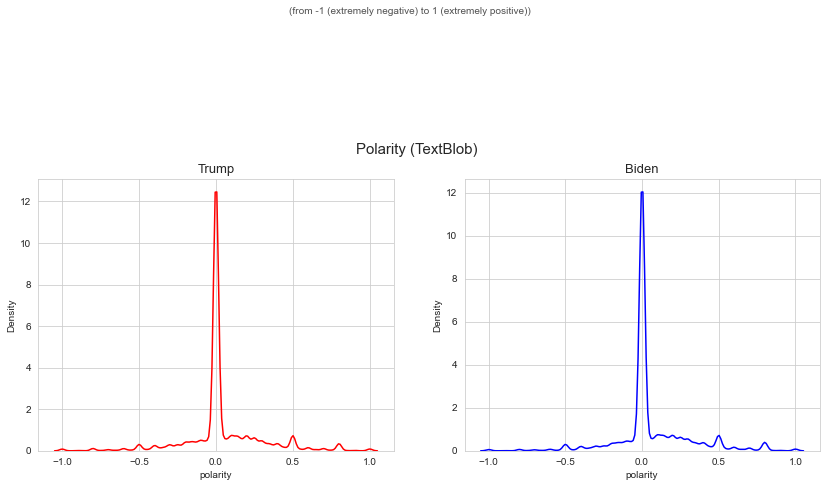

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.set_style("whitegrid")
plt.suptitle('Polarity (TextBlob)', size = 15)
plt.text(x=-2.3, y=20.3, s='(from -1 (extremely negative) to 1 (extremely positive))', fontsize=10, alpha=0.8)


sns.kdeplot(trump_cleaned['polarity'], color = 'red', ax = ax1, legend = False)
ax1.set_title('Trump', size = 13)

sns.kdeplot(biden_cleaned['polarity'], color = 'blue', ax = ax2, legend = False)
ax2.set_title('Biden', size = 13)

fig.show()

Let's take a look at some extremely positive and extremely negative tweets of both candidates.

In [50]:
# Trump negative tweets
trump_cleaned[trump_cleaned['polarity'] == -1]['tweet'][:5]

27      comments on this do democrats understand how r...
217     the thought of having to hear the insane ravin...
694                 trump is the worst president ever    
976     schoolchoice vote freedom trump whyvoteleft di...
1040    presidential debate trumps insult to biden fam...
Name: tweet, dtype: object

In [51]:
# Trump positive tweets
trump_cleaned[trump_cleaned['polarity'] == 1]['tweet'][:5]

211    via rawstory its been one faceplant after anot...
437                how awesome my twitterversary  trump 
560    excellent show him the door  cdnpoli abpoli us...
663    realdonaldtrump another best people from trump...
740          mummy always knows best  trump  uspolitics 
Name: tweet, dtype: object

In [52]:
# Biden negative tweets
biden_cleaned[biden_cleaned['polarity'] == -1]['tweet'][:5]

17     comments on this do democrats understand how r...
142    bye bye biden watching tuckercarlson  devastating
360    no today were going to make the evil nutter a ...
891    cocainelaced cigarettes crack and vodka binges...
994    presidential debate trumps insult to biden fam...
Name: tweet, dtype: object

In [53]:
# Biden positive tweets
biden_cleaned[biden_cleaned['polarity'] == 1]['tweet'][:5]

649     joe biden at his best remember when joebiden c...
1254    excellent analysis by tucker carlson of bidene...
1262    chrismegerian no it just publishes the email f...
1456    we gave obama and vp joebiden a democrat congr...
1526    the best way for joebiden to tackle the nypost...
Name: tweet, dtype: object

Not perfect (because the data still dirty, and the TextBlob method not 100% effective), but it works well enough. Let's try VADER method that works better with negative sentiment.

In [54]:
# VADER Analyzer
sid = SentimentIntensityAnalyzer()

# Text polarity function
def get_vader_score(data):
    return sid.polarity_scores(data)['compound']

trump_cleaned['VADER'] = trump_cleaned['tweet'].apply(lambda x: get_vader_score(x))
biden_cleaned['VADER'] = biden_cleaned['tweet'].apply(lambda x: get_vader_score(x))

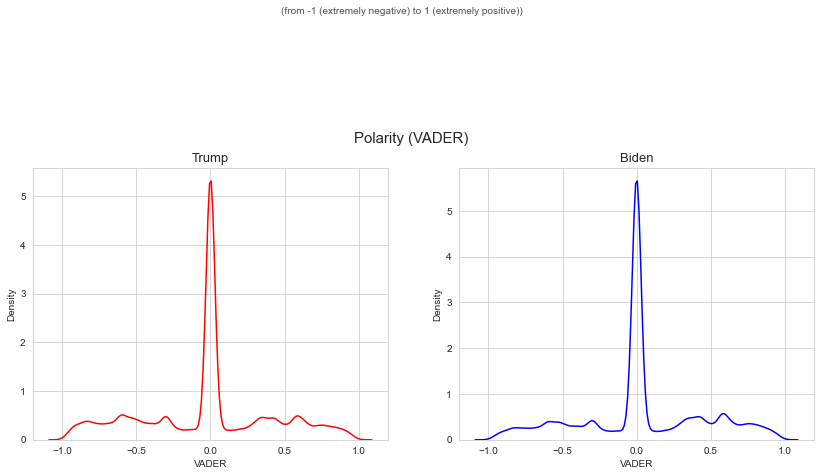

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.set_style("whitegrid")
plt.suptitle('Polarity (VADER)', size = 15)
plt.text(x=-2.4, y=9.3, s='(from -1 (extremely negative) to 1 (extremely positive))', fontsize=10, alpha=0.8)


sns.kdeplot(trump_cleaned['VADER'], color = 'red', ax = ax1, legend = False)
ax1.set_title('Trump', size = 13)

sns.kdeplot(biden_cleaned['VADER'], color = 'blue', ax = ax2, legend = False)
ax2.set_title('Biden', size = 13)

fig.show()

Yes, with VADER the percentage of neutral polarities (close to zero) decreased in the negative direction.

In [56]:
print(trump_cleaned['tweet'].loc[1435])
print('*'*20)
print(trump_cleaned[['polarity', 'VADER']].loc[1435])

mtgreenee documenting for fbi investigation into nationalsecurity criminal conduct ofpoliticians what does ipcc usgcrp stateabout climatechange what action have you taken as potus is actingwith willful blindness criminal negligence committing ecocide  trump foxnews
********************
polarity   -0.233333
VADER      -0.757900
Name: 1435, dtype: float64


In [57]:
print(biden_cleaned['tweet'].loc[296157])
print('*'*20)
print(biden_cleaned[['polarity', 'VADER']].loc[296157])

mondaythoughts i believe melaniatrump is voting for biden when she speaks it seems rehearsed or forced she never appears happy in public with donnie she knows shes in captivity amp itll be hell to pay if she wants out
********************
polarity    0.175
VADER      -0.900
Name: 296157, dtype: float64


Wow, VADER really looks better at recognizing negative sentiment.

In [58]:
# create 'date' feature
trump_cleaned['date'] = pd.to_datetime(trump_cleaned['created_at']).dt.date
biden_cleaned['date'] = pd.to_datetime(biden_cleaned['created_at']).dt.date

In [59]:
def create_line_plot(data1, data2, FUN, ax, title):
    sns.lineplot(data = data1.groupby('date')[FUN].mean(), 
                 label = 'Trump', color = 'red', linewidth = 3, ax = ax)
    sns.lineplot(data = data2.groupby('date')[FUN].mean(), 
                 label = 'Biden', color = 'blue', linewidth = 3, ax = ax)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.set_title(title, size = 13)
    ax.legend(prop={'size': 14})
    ax.set_ylabel('Polarity')

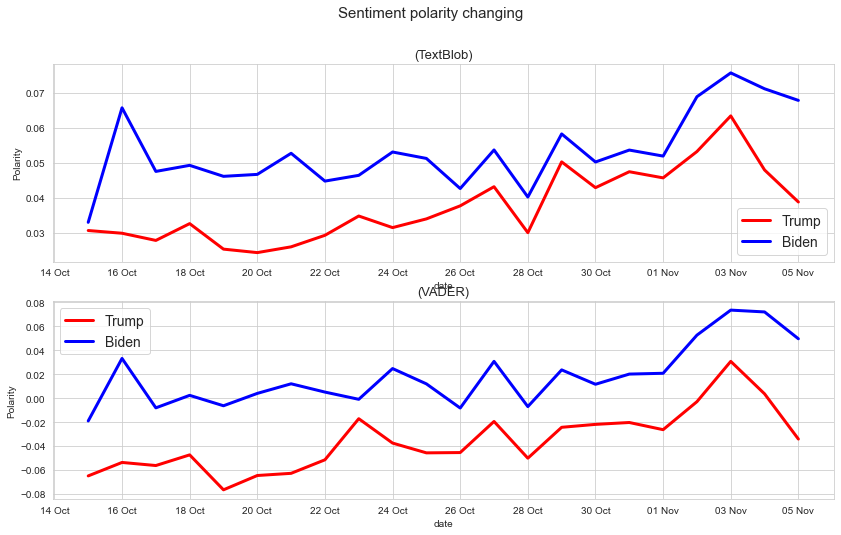

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
sns.set_style("whitegrid")
plt.suptitle('Sentiment polarity changing', size = 15)

create_line_plot(trump_cleaned, biden_cleaned, 'polarity', ax1, '(TextBlob)')
create_line_plot(trump_cleaned, biden_cleaned, 'VADER', ax2, '(VADER)')

fig.show()

It looks like tweets dedicated to Joe Biden were more positive throughout the studied period. But these are average values. We should look at the changes in the polarity of positive and negative tweets separately.

In [61]:
# Working datasets
# Trump
tb_pos_tr = trump_cleaned[trump_cleaned['polarity'] > 0]
tb_neg_tr = trump_cleaned[trump_cleaned['polarity'] < 0]
vader_pos_tr = trump_cleaned[trump_cleaned['VADER'] > 0]
vader_neg_tr = trump_cleaned[trump_cleaned['VADER'] < 0]

# Biden
tb_pos_bi = biden_cleaned[biden_cleaned['polarity'] > 0]
tb_neg_bi = biden_cleaned[biden_cleaned['polarity'] < 0]
vader_pos_bi = biden_cleaned[biden_cleaned['VADER'] > 0]
vader_neg_bi = biden_cleaned[biden_cleaned['VADER'] < 0]

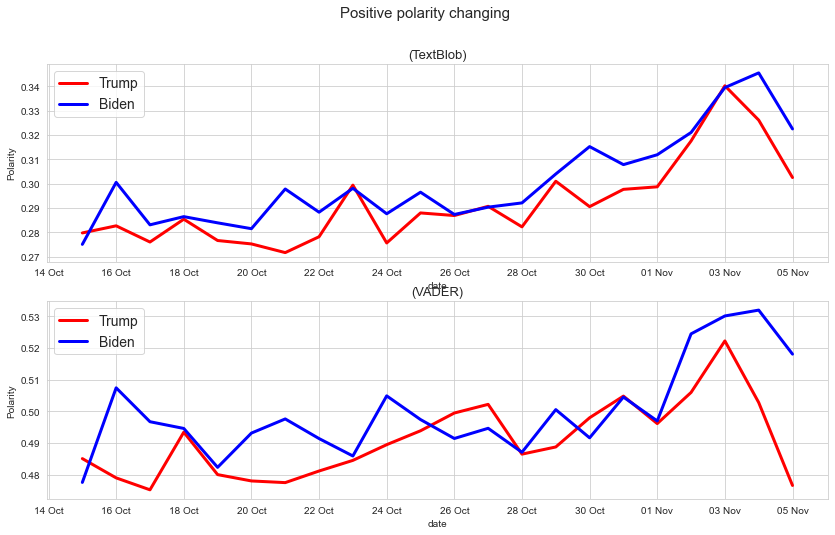

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
sns.set_style("whitegrid")
plt.suptitle('Positive polarity changing', size = 15)

create_line_plot(tb_pos_tr, tb_pos_bi, 'polarity', ax1, '(TextBlob)')
create_line_plot(vader_pos_tr, vader_pos_bi, 'VADER', ax2, '(VADER)')

fig.show()

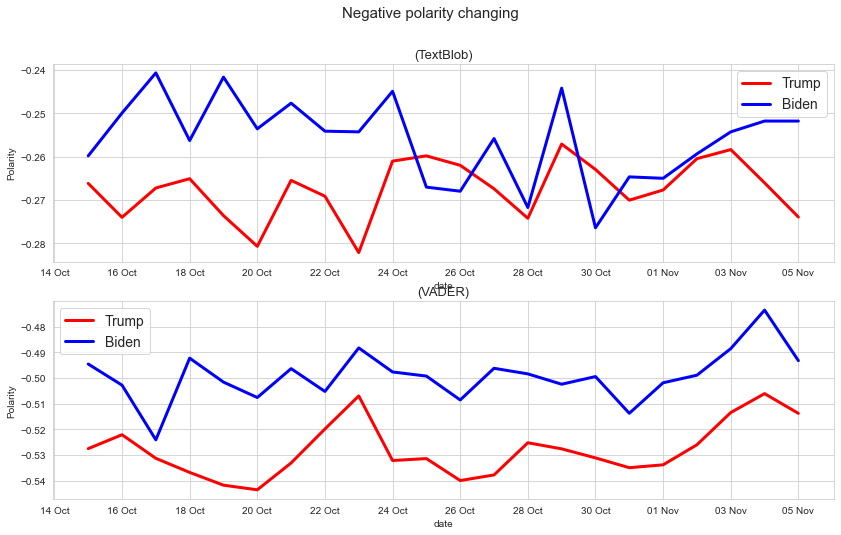

In [63]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
sns.set_style("whitegrid")
plt.suptitle('Negative polarity changing', size = 15)

create_line_plot(tb_neg_tr, tb_neg_bi, 'polarity', ax1, '(TextBlob)')
create_line_plot(vader_neg_tr, vader_neg_bi, 'VADER', ax2, '(VADER)')

fig.show()

It's time for sentiment classification of users.

In [64]:
trump_users_pol = trump_cleaned.groupby('user_name')['polarity', 'VADER'] \
    .mean().sort_values('polarity', ascending = False)

biden_users_pol = biden_cleaned.groupby('user_name')['polarity', 'VADER'] \
    .mean().sort_values('polarity', ascending = False)

In [65]:
# Datasets
trump_top_authors_by_count = pd.merge(trump_top_authors_by_count, 
                                      trump_users_pol, on = 'user_name', 
                                      how = 'left').sort_values('VADER', ascending = True)

biden_top_authors_by_count = pd.merge(biden_top_authors_by_count, 
                                      biden_users_pol, on = 'user_name', 
                                      how = 'left').sort_values('VADER', ascending = True)

trump_top_authors_by_likes = pd.merge(trump_top_authors_by_likes, 
                                      trump_users_pol, on = 'user_name', 
                                      how = 'left').sort_values('VADER', ascending = True)

biden_top_authors_by_likes = pd.merge(biden_top_authors_by_likes, 
                                      biden_users_pol, on = 'user_name', 
                                      how = 'left').sort_values('VADER', ascending = True)

In [66]:
def create_lollipop_plot(data, ax, first_color, second_color, title):
    ax.hlines(y = data['user_name'], xmin = data['polarity'], 
               xmax = data['VADER'], color = first_color, alpha = 0.5)
    ax.scatter(data['polarity'], data['user_name'], color = first_color, 
                alpha = 1, edgecolors = 'black', label = 'TextBlob')
    ax.scatter(data['VADER'], data['user_name'], color = second_color, 
                alpha = 1, edgecolors = 'black', label = 'VADER')
    ax.legend()
    ax.set_xlim(-1, 1)
    ax.axvline(x = 0, linestyle = '--', color = 'black', linewidth = 0.7)
    ax.set_title(title)

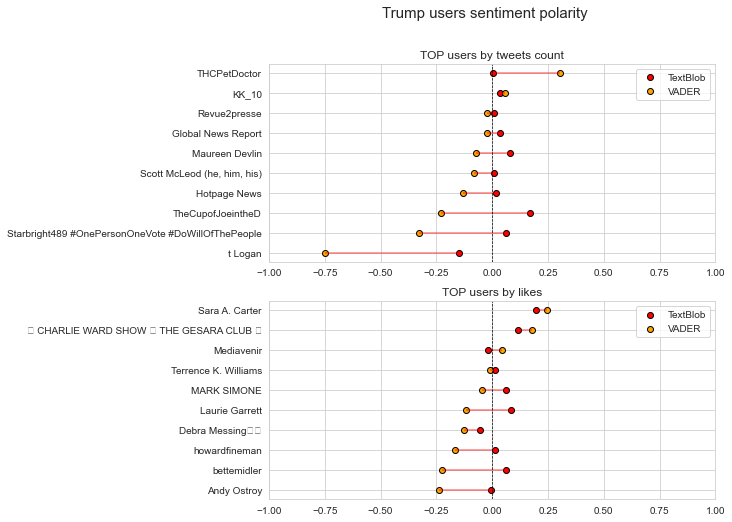

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
sns.set_style("whitegrid")
fig.suptitle('Trump users sentiment polarity', size = 15)

create_lollipop_plot(trump_top_authors_by_count, ax1, 'red', 'orange',
                     'TOP users by tweets count')

create_lollipop_plot(trump_top_authors_by_likes, ax2, 'red', 'orange',
                     'TOP users by likes')

fig.show()

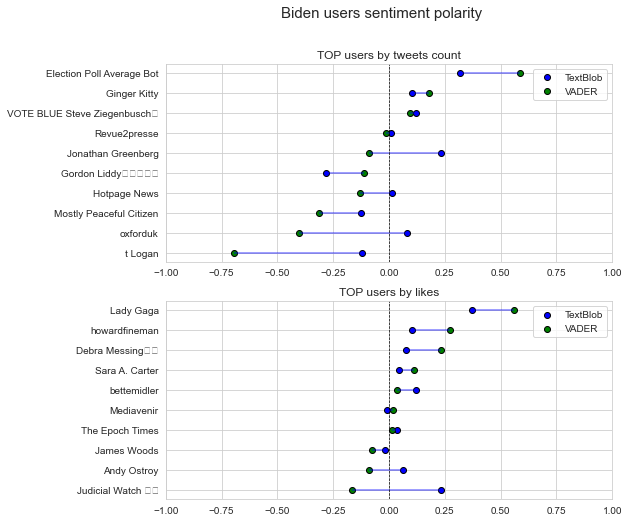

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
sns.set_style("whitegrid")
fig.suptitle('Biden users sentiment polarity', size = 15)

create_lollipop_plot(biden_top_authors_by_count, ax1, 'blue', 'green',
                     'TOP users by tweets count')

create_lollipop_plot(biden_top_authors_by_likes, ax2, 'blue', 'green',
                     'TOP users by likes')

fig.show()

And also we should look at the sentiment polarity of TOP-countries.

In [69]:
# Datasets
tr_top_countries = trump_cleaned[trump_cleaned.country.isin(trump_tweets_countries.index)]
bi_top_countries = biden_cleaned[biden_cleaned.country.isin(biden_tweets_countries.index)]

trump_countries_pol = tr_top_countries.groupby('country')['polarity', 'VADER'] \
    .mean().sort_values('polarity', ascending = True)

biden_countries_pol = bi_top_countries.groupby('country')['polarity', 'VADER'] \
    .mean().sort_values('polarity', ascending = True)

In [70]:
def create_lollipop_plot_2(data, ax, first_color, second_color, title):
    ax.hlines(y = data.index, xmin = data['polarity'], 
               xmax = data['VADER'], color = first_color, alpha = 0.5)
    ax.scatter(data['polarity'], data.index, color = first_color, 
                alpha = 1, edgecolors = 'black', label = 'TextBlob')
    ax.scatter(data['VADER'], data.index, color = second_color, 
                alpha = 1, edgecolors = 'black', label = 'VADER')
    ax.legend()
    ax.set_xlim(-1, 1)
    ax.axvline(x = 0, linestyle = '--', color = 'black', linewidth = 0.7)
    ax.set_title(title)

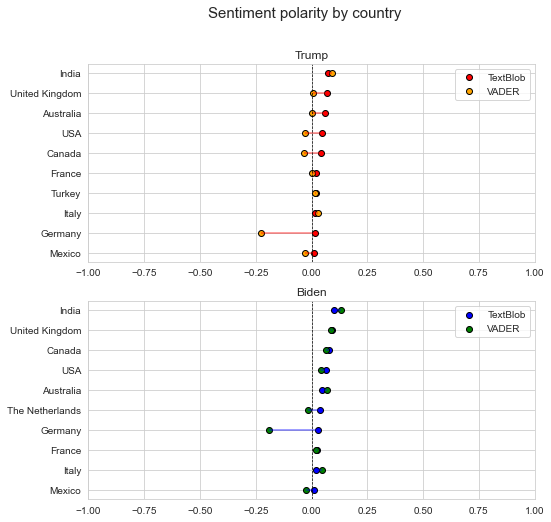

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
sns.set_style("whitegrid")
fig.suptitle('Sentiment polarity by country', size = 15)

create_lollipop_plot_2(trump_countries_pol, ax1, 'red', 'orange',
                     'Trump')

create_lollipop_plot_2(biden_countries_pol, ax2, 'blue', 'green',
                     'Biden')

fig.show()

So, we've taken a quick look at the sentiment of tweets. There are a lot of analysis variants. It looks great to study the polarity of tweets by cities, or states, for instance, but these features have a lot of NaN values, and therefore don't cover the actual situation. 